
## Overview

**Objective.** Our goal is to generate an adversarial image starting with the target image such that we minimize the $\ell^2$ distance to the source image while having the classifier predict the target image’s label, using as few queries as possible:

#### Problem Statement

We consider a classifier

\begin{equation*}
f: [0,1]^{C \times H \times W} \to \mathbb{R}^K,
\end{equation*}

where \(C\), \(H\), and \(W\) are the number of color channels, height, and width, respectively, and \(K\) is the number of classes. For any input \(x\), we only observe the top-1 label:

\begin{equation*}
\hat y(x) = \arg\max_{1 \le k \le K} [f(x)]_k.
\end{equation*}

We start with a correctly classified source image $x_s$ (label $y_s$) and a target image $x_t$ (label $y_t$). Our adversarial objective is:

\begin{equation*}
x_{\mathrm{adv}} = \arg\min_x \|x - x_s\|_2
\quad \text{subject to} \quad
\hat y(x) = y_t.
\end{equation*}

In our methodology, we detect the edges present in the target image, and avoid making perturbations around them. Hence, we implement a two-step edge informed methodology:

1. **Global edge-informed search** to coarsely align major regions.
2. **Patch-based edge-informed search** to refine local perturbations without gradient queries.

Neither step uses gradients or the boundary geometry; this avoids wasting queries early in a broad decision space.


## 1 ▸ Setup

First, we setup the environment to implement Targeted Edge-informed Attack (TEA). The following cell imports the required libraries and modules, suppresses the deprecation warnings from `torchvision` and `timm`, and pre-downloads the pretrained weights for ResNet50, ResNet101, VGG16, and ViT. By caching these weights up front, later calls to initialize any of these models will load instantly from the local cache rather than downloading them at runtime.

In [1]:
import os
import warnings
import torchvision.models as torch_models
import timm
from TEA import initialize_attack, edge_mask_initialization, global_edge_informed_search, patch_based_edge_informed_search
from utils import get_device, get_model_choice, get_transform, get_sorted_image_pairs, load_and_transform_image, validate_pair_id, get_pair_files

warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.models._utils")

print("Downloading and caching all model weights.")
for name in ("resnet50", "resnet101", "vgg16"):
    _tmp = getattr(torch_models, name)(pretrained=True)
    del _tmp

_viT = timm.create_model("vit_base_patch16_224", pretrained=True)
del _viT

print("Done!  All weights are now cached locally.")

Done!  All weights are now cached locally.


In the `../ILSVRC2012_val_pairs` folder you will find **five** pairs of images randomly selected from the ImageNet validation set.

Choose a **`pair_id`** between **1** and **5** to run the attack on the corresponding image pair.

In [2]:
pair_id = 1


## 2 ▸ Inspect and validate the source–target pair

In this cell we:

1. **Initialize model architecture**
   Choose one of the following and enter it when prompted:
   - `resnet50`  (ResNet-50)
   - `resnet101` (ResNet-101)
   - `vgg16`     (VGG-16)
   - `ViT`       (Vision Transformer)

2. **Validate classes**
   - Treat files ending in `_a.JPEG` as the source image ($x_s$) and `_b.JPEG` as the target image ($x_t$).
   - Run both through the selected model and abort if they share the same top-1 prediction (since the attack must be targeted).

3. **Visualize & measure**
   - Display $x_s$ and $x_t$ along with their predicted labels.
   - Compute and report the $\ell^2$ distance $\|x_t - x_s\|_2$.

Chosen architecture: resnet50

Processing pair 1: 1a.JPEG -> 1b.JPEG.


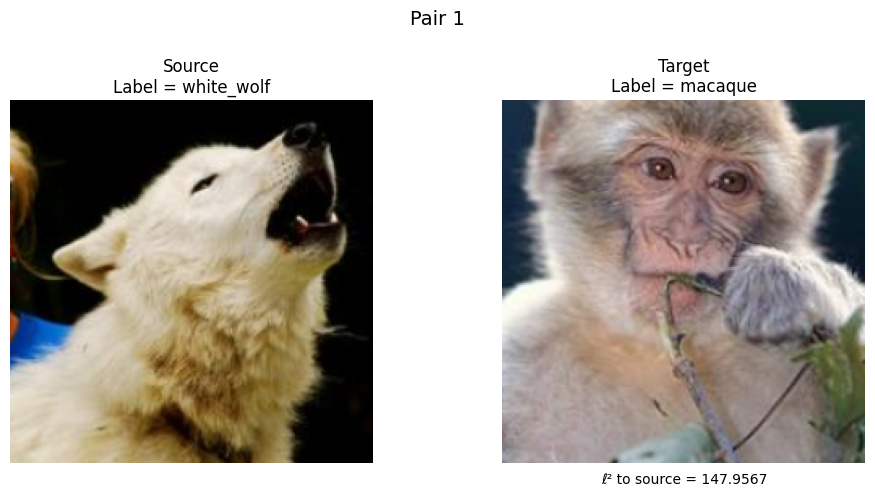

In [3]:
folder = "../ILSVRC2012_val_pairs"
device = get_device()
transform = get_transform()
model_arch = get_model_choice()
files = get_sorted_image_pairs(folder)
validate_pair_id(pair_id, len(files))

file_a, file_b = get_pair_files(files, pair_id)
print(f"Chosen architecture: {model_arch}")
print(f"\nProcessing pair {pair_id}: {file_a} -> {file_b}.")

image_a = load_and_transform_image(os.path.join(folder, file_a), transform)
image_b = load_and_transform_image(os.path.join(folder, file_b), transform)

initialization = initialize_attack(pair_id, image_a, image_b, model_arch=model_arch)

## 3 ▸ Soft-edge Mask of Target Image

In this step, we follow **Algorithm 1** from the paper to generate a _soft edge mask_ $M_{\text{edge}}$ for our target image $x_t$. First, we apply a Sobel filter [1] to detect high-gradient (edge) locations. Then we blur those edges so that $M_{\text{edge}}(i,j)\in[0,1]$ takes values close to 1 at strong edges and smoothly decays toward 0 in flatter regions. This “softening” encourages perturbations to spread out, preventing them generating adversarial images in narrow decision spaces. We visualize this below by plotting the edges in white, and smooth regions in black.



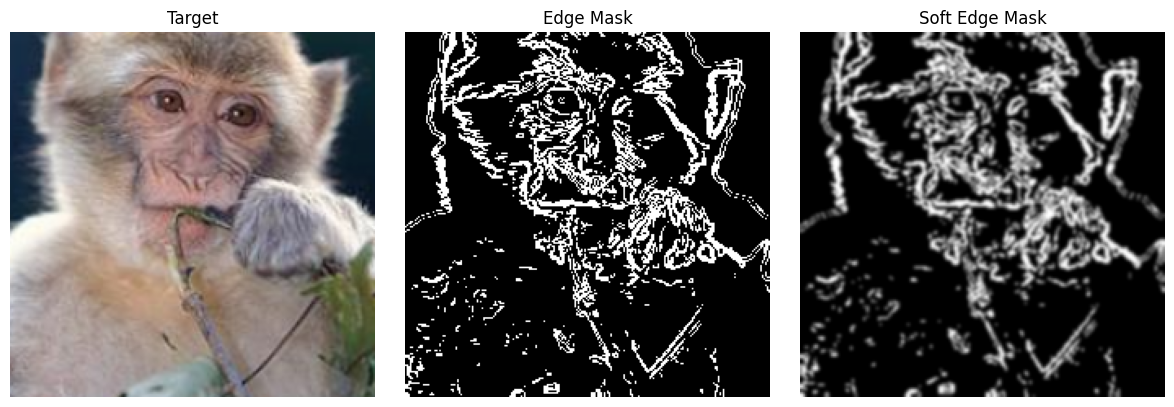

In [4]:
soft_edge_mask = edge_mask_initialization(*initialization[1:5])

## 4 ▸ Global Edge-informed Search


We now begin our attack by running **Algorithm 2** to apply a global, edge‐aware interpolation that moves our target image $x_t$ closer to the source image $x_s$ while preserving the edges that help maintain the target classification. Below, we visualize the first three iterations of the search and the final result of this global edge‐informed search.

> **Global Interpolation.**
> Starting from $x_0 = x_t$, we perform iterative updates:
> $$x_{k+1} \leftarrow x_k + \alpha\,(x_s - x_k)\;\odot\;\bigl(I - M_{\mathrm{edge}}\bigr),$$
> where $\odot$ is the element‐wise product, $\alpha$ is chosen via a momentum‐based line search, and $(I - M_{\mathrm{edge}})$ masks out edge regions so that updates focus on smooth areas. This preserves critical structure for target classification.

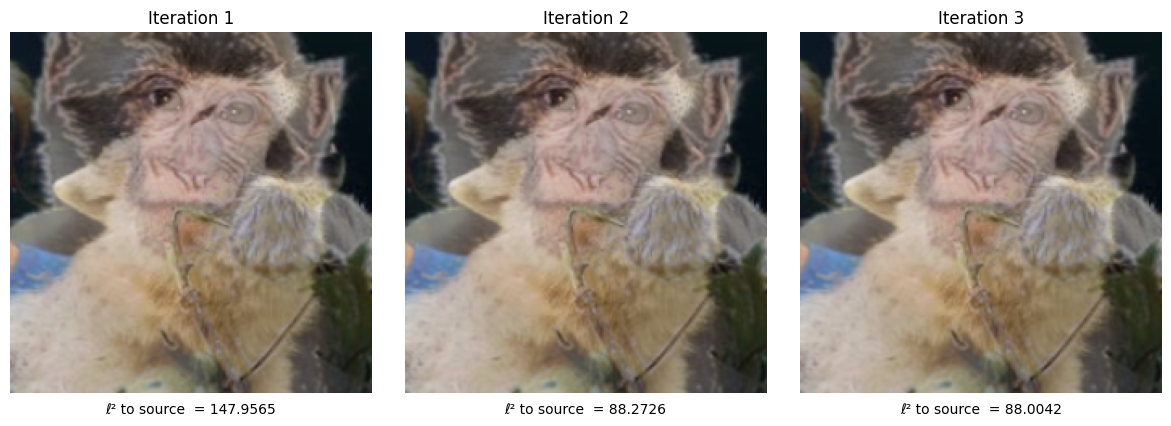

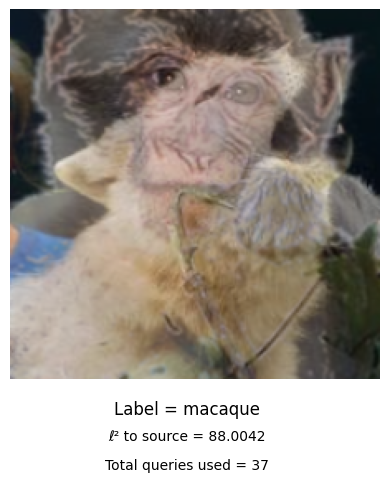

In [5]:
global_result = global_edge_informed_search(soft_edge_mask, *initialization, iterations_to_show=3)

## 5 ▸ Patch-based Edge-informed Search

On our adversarial image, we now implement **Algorithm 3** to apply local, patch-wise perturbations. We visualize the first three patch updates along with their locations, and then show the final result of the patch-based search. With this, the TEA attack completes and we reach the _“turning-point”_.

> **Patch-Based Edge-Informed Search.**
> After the global interpolation, some subregions still differ significantly from $x_s$. We partition the image into patches
> $$\mathcal{P}\subseteq\{1,\dots,H\}\times\{1,\dots,W\},$$
> and for each patch construct a local soft edge mask $M_{\mathcal{P}}$ (analogous to $M_{\mathrm{edge}}$, but restricted to $\mathcal{P}$). We then perform a local interpolation
> $$\widetilde{x}(\beta) \;=\; x_k \;+\;\beta\,(x_s - x_k)\;\odot\;G\;\odot\;(I - M_{\mathcal{P}}),$$
> and search for the largest $\beta$ such that $\hat y(\widetilde x(\beta)) = y_t$. Here, $G$ is a Gaussian weight over the patch to avoid creating artificial edges. We repeat this over multiple patches of varying sizes until no further improvement occurs (e.g.\ 25 consecutive iterations).

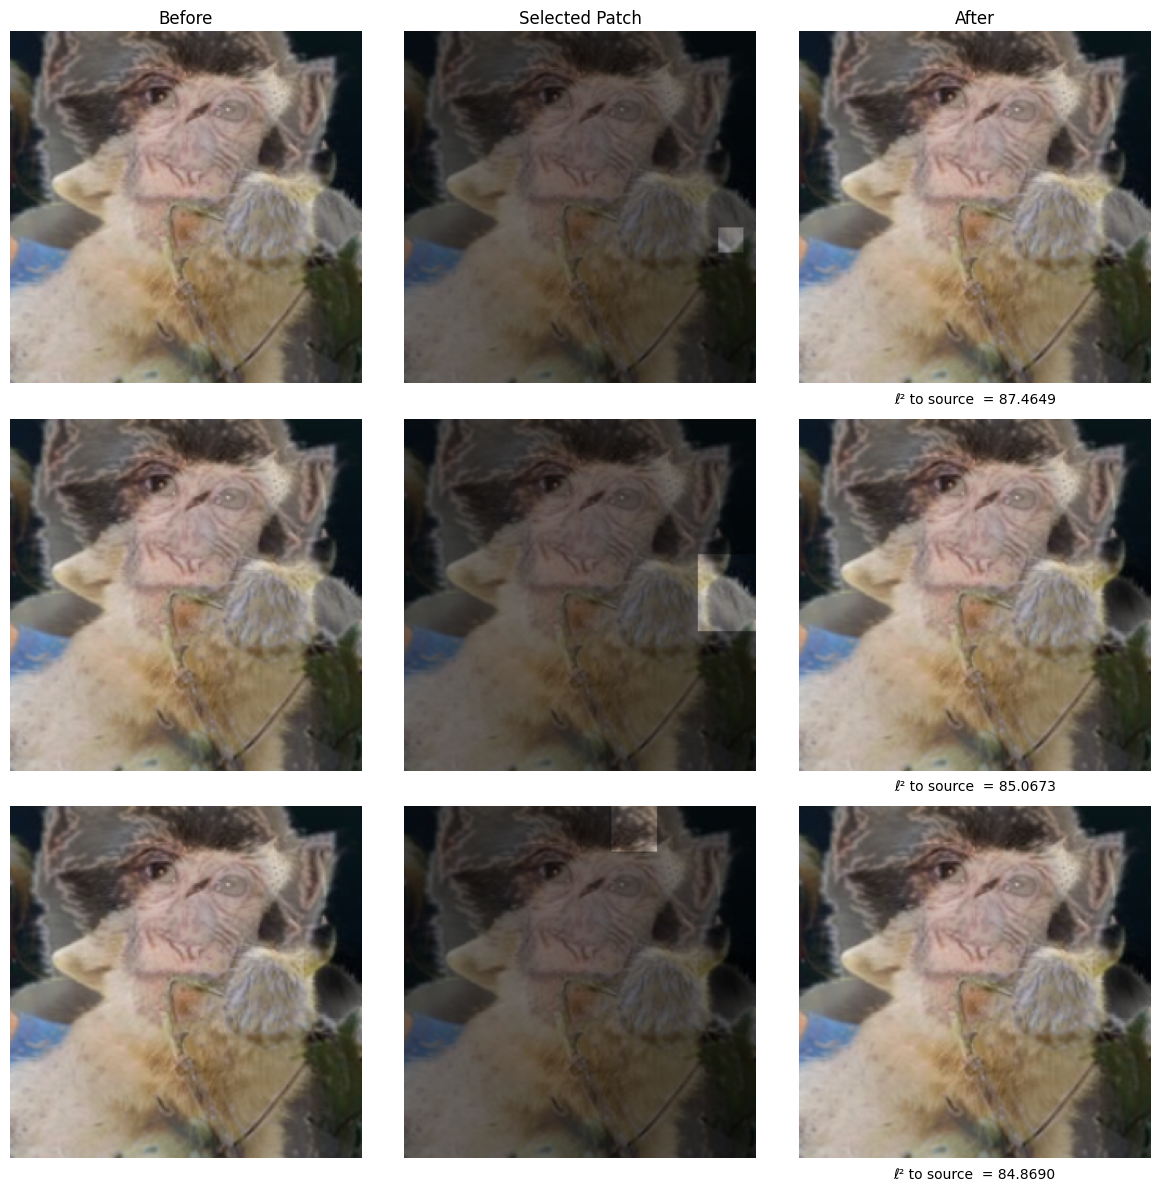

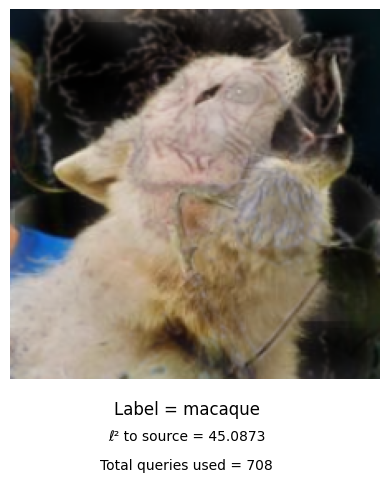

In [6]:
x_adv, total_calls = patch_based_edge_informed_search(*global_result,model_arch=model_arch,file_a= file_a,file_b=file_b,iterations_to_show=3)

## Appendix ▸ CGBA/CGBA-H for further refinement

Here we use the result of TEA as a starting image to run CGBA-H [2] for further refinement in case more queries are available.